<a href="https://colab.research.google.com/github/senriquez2/Final-Project/blob/main/ScatterVennDiagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd

# Load the data from GitHub

github_raw_url = 'https://raw.githubusercontent.com/senriquez2/Final-Project/refs/heads/main/Data_Final.csv'
df = pd.read_csv(github_raw_url)


Data Loaded & Transformed. Generating Venn Diagram...


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579:

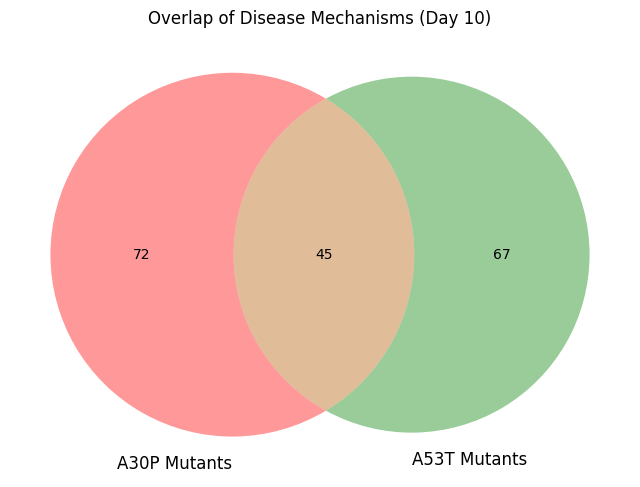


INTERPRETATION:
A30P Specific Hits: 72
A53T Specific Hits: 67
SHARED Hits: 45


In [7]:
# 1. INSTALL LIBRARY
# (If this fails, run '!pip install matplotlib-venn' in a separate cell first)
try:
    import matplotlib_venn
except ImportError:
    !pip install matplotlib-venn
    import matplotlib_venn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from scipy import stats

# --- 2. LOAD & PREP DATA (The Master Logic) ---

# Use the GitHub raw URL to load the CSV file
github_raw_url = 'https://raw.githubusercontent.com/senriquez2/Final-Project/refs/heads/main/Data_Final.csv'
df = pd.read_csv(github_raw_url)
df.columns = df.columns.str.strip() # Fix spaces

# Rename to standard names (Required for the analysis code to work)
rename_map = {
    'Alpha _day_1_1': 'WT_day_1_1', 'Alpha _day_1_2': 'WT_day_1_2',
    'Alpha _day_10_1': 'WT_day_10_1', 'Alpha _day_10_2': 'WT_day_10_2',
    'Alpha _day_30_1': 'WT_day_30_1', 'Alpha _day_30_2': 'WT_day_30_2',
    'Alpha A30P_day_1_1': 'A30P_day_1_1', 'Alpha A30P_day_1_2': 'A30P_day_1_2',
    'Alpha A30P_day_10_1': 'A30P_day_10_1', 'Alpha A30P_day_10_2': 'A30P_day_10_2',
    'Alpha A53T_day_1_1': 'A53T_day_1_1', 'Alpha A53T_day_1_2': 'A53T_day_1_2',
    'Alpha A53T_day_10_1': 'A53T_day_10_1', 'Alpha A53T_day_10_2': 'A53T_day_10_2',
    'Alpha A53T_day_30_1': 'A53T_day_30_1', 'Alpha A53T_day_30_2': 'A53T_day_30_2'
}
df_clean = df.rename(columns=rename_map)
cols = ['Gene names'] + list(rename_map.values())
df_clean = df_clean[[c for c in cols if c in df_clean.columns]]

# Clean & Log2 Transform
df_clean = df_clean.dropna(subset=['Gene names'])
df_clean['Gene names'] = df_clean['Gene names'].astype(str) # Ensure gene names are strings
df_clean = df_clean.set_index('Gene names')
df_clean.index = df_clean.index.astype(str) # Explicitly ensure index is string type

# Apply pd.to_numeric to all data columns, coercing errors
df_clean = df_clean.apply(pd.to_numeric, errors='coerce')

# Select only numeric columns before groupby().sum() to avoid type errors
numeric_cols = df_clean.select_dtypes(include=np.number).columns
df_clean = df_clean[numeric_cols].groupby(level=0).sum()

df_clean = df_clean.replace(0, np.nan)
min_val = df_clean.min().min()
df_log2 = np.log2(df_clean.fillna(min_val))

print("Data Loaded & Transformed. Generating Venn Diagram...")

# --- 3. DEFINE "SIGNIFICANT GENE" FINDER ---
def get_sig_genes(df, case_cols, ctrl_cols):
    sig_list = []
    for gene in df.index:
        case_vals = df.loc[gene, case_cols].dropna()
        ctrl_vals = df.loc[gene, ctrl_cols].dropna()

        if len(case_vals) < 2 or len(ctrl_vals) < 2: continue

        # Stats: T-Test & Fold Change
        _, p = stats.ttest_ind(case_vals, ctrl_vals, equal_var=False)
        fc = case_vals.mean() - ctrl_vals.mean()

        # Cutoffs: P < 0.05 AND FC > 0.58 (1.5x)
        if p < 0.05 and abs(fc) > 0.58:
            sig_list.append(gene)

    return set(sig_list)

# --- 4. CALCULATE OVERLAP (Day 10) ---
# Find genes broken in A30P
a30p_genes = get_sig_genes(df_log2,
                           ['A30P_day_10_1', 'A30P_day_10_2'],
                           ['WT_day_10_1', 'WT_day_10_2'])

# Find genes broken in A53T
a53t_genes = get_sig_genes(df_log2,
                           ['A53T_day_10_1', 'A53T_day_10_2'],
                           ['WT_day_10_1', 'WT_day_10_2'])

# --- 5. PLOT ---
plt.figure(figsize=(8, 8))
venn2([a30p_genes, a53t_genes], ('A30P Mutants', 'A53T Mutants'))
plt.title('Overlap of Disease Mechanisms (Day 10)')
plt.show()

# Interpretation Text
overlap = len(a30p_genes.intersection(a53t_genes))
print(f"\nINTERPRETATION:")
print(f"A30P Specific Hits: {len(a30p_genes - a53t_genes)}")
print(f"A53T Specific Hits: {len(a53t_genes - a30p_genes)}")
print(f"SHARED Hits: {overlap}")

Found 8 conditions to check reproducibility.


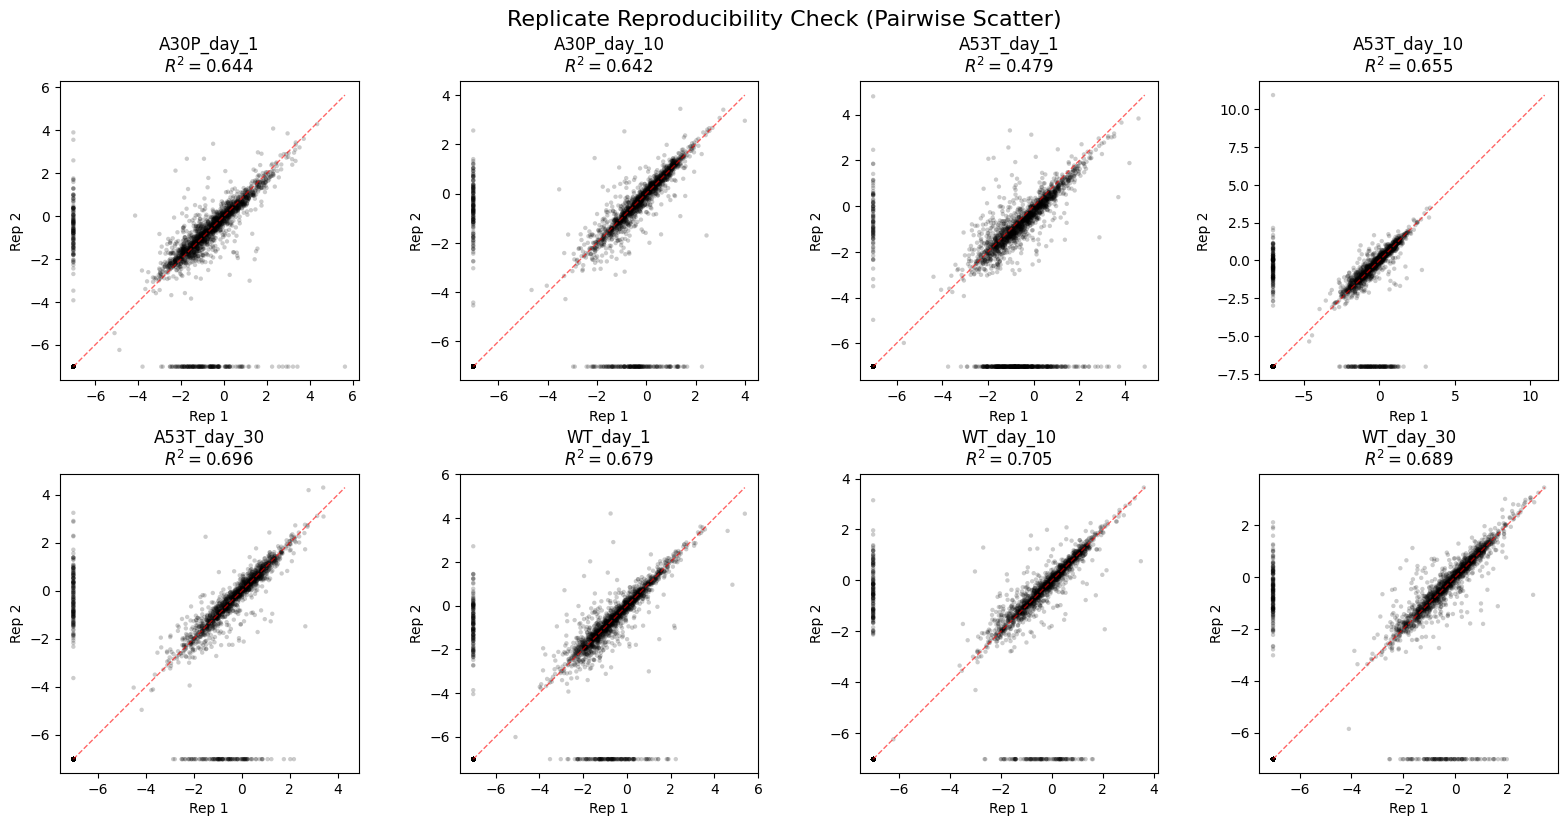

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import math

# 1. IDENTIFY CONDITIONS
# We look for columns that share the same prefix (e.g., "WT_day_1")
# This logic assumes names end in "_1", "_2"
conditions = sorted(list(set(["_".join(c.split('_')[:-1]) for c in df_log2.columns])))

print(f"Found {len(conditions)} conditions to check reproducibility.")

# 2. SETUP THE GRID (The "Major Plot")
# We make a grid (e.g., 4 columns wide)
cols = 4
rows = math.ceil(len(conditions) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(16, rows*4))
axes = axes.flatten() # Flatten the 2D grid to a 1D list for easy looping

# 3. FILL THE GRID
for i, cond in enumerate(conditions):
    ax = axes[i]

    rep1 = f"{cond}_1"
    rep2 = f"{cond}_2"

    # Check if columns exist
    if rep1 in df_log2.columns and rep2 in df_log2.columns:
        x = df_log2[rep1]
        y = df_log2[rep2]

        # Calculate Stats (R-squared)
        r, _ = pearsonr(x, y)
        r2 = r**2

        # Plot Scatter (Black dots, transparent to see density)
        ax.scatter(x, y, c='black', s=10, alpha=0.2, edgecolor='none')

        # Add "Perfect Match" Line (Red dashed)
        lims = [min(x.min(), y.min()), max(x.max(), y.max())]
        ax.plot(lims, lims, 'r--', alpha=0.6, linewidth=1)

        # Labels & Title
        ax.set_title(f"{cond}\n$R^2 = {r2:.3f}$") # LaTeX formatting for math
        ax.set_xlabel('Rep 1')
        ax.set_ylabel('Rep 2')

        # Force square aspect ratio (crucial for diagonal comparison)
        ax.set_aspect('equal')
    else:
        ax.text(0.5, 0.5, "Missing Data", ha='center')
        ax.axis('off')

# 4. CLEANUP (Hide empty slots)
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Replicate Reproducibility Check (Pairwise Scatter)", y=1.02, fontsize=16)
plt.show()